### Load datasets

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import davies_bouldin_score

Aggregation = pd.read_table("Aggregation.txt",sep = ' ',header=None)
D31 = pd.read_table("D31.txt",sep = ' ',header=None)
R15 = pd.read_table("R15.txt",sep = ' ',header=None)

In [2]:
colors = {
    -2: 'black',
    0: 'red',
    1: 'orange',
    2: 'yellow',
    3: 'green',
    4: 'cyan',
    5: 'blue',
    6: 'purple',
    7: 'brown',
    8: 'gray',
    9: 'olive',
    10: 'chocolate'
}

### DPC

In [3]:
class DPC(object):
    def __init__(self,dc,kernel = 'sign'):
        """
        dc: hyperparameter threshold
        Specially for 2 dimensional dataset
        kernel: choose sign of gauss
        """
        self.dc = dc
        self.dij = None # 距离矩阵（欧式距离）
        self.rho = None # density
        self.delta = None
        self.rho_threshold = None # rho的阈值
        self.delta_threshold = None # delta的阈值
        self.kernel = kernel # choose the kernel
        self.index = None # 记录索引
        self.cluster_list = None # 记录每个点归属的聚类中心

    def cal_dij(self,X):
        """
        该函数计算样本距离矩阵
        X: 样本
        计算两个样本点之间的欧式距离
        """
        samp_num = X.shape[0]
        self.dij = np.zeros((samp_num,samp_num))
        for i in range(samp_num):
            for j in range(i+1, samp_num):
                self.dij[i,j] = np.linalg.norm(X.iloc[i,:] - X.iloc[j,:])
                self.dij[j,i] = self.dij[i,j] # 对称三角矩阵

    def cal_rho(self,X):
        """
        计算样本的rho
        可以选用阶跃函数和高斯函数两种方法
        """

        n = X.shape[0]
        if self.dij is None:
            self.cal_dij(X)
        
        if self.kernel == 'sign':
            self.rho = np.zeros(n) # store rho
            for i in range(n):
                ans = 0
                for j in range(n):
                    if self.dij[i,j] < self.dc:
                        ans += 1
                    self.rho[i] = ans

        elif self.kernel == 'gauss':
            self.rho = np.sum(np.exp((-self.dij ** 2) / (self.dc ** 2)),axis=1)

        return self.rho


    def cal_delta(self,X):
        """
        计算delta,同时对每个点记录离它近的且密度比它大的数据点
        """
        if self.rho is None:
            self.cal_rho(X)

        self.delta = np.zeros(self.rho.shape[0]) # store delta
        max_rho = np.max(self.rho) # 记录rho的最大值
        self.index = np.zeros(self.rho.shape[0]).astype('int')

        for i,di in enumerate(self.dij):
            if self.rho[i] == max_rho:
                self.delta[i] = np.max(di)
                self.index[i] = i
            else:
                di[self.rho <= self.rho[i]] = float("inf")
                self.delta[i] = np.min(di)
                self.index[i] = np.argmin(di) # 记录索引

        return self.delta, self.index

    def dpc(self,X):
        self.dij = self.cal_dij(X)
        self.rho = self.cal_rho(X)
        self.delta, self.index = self.cal_delta(X)

    def decision_graph(self,X):
        """
        绘制决策图
        """
        if self.rho is None:
            self.dpc(X)
        #from matplotlib import pyplot as plt
        plt.title('Decision graph')
        plt.xlabel('rho')
        plt.ylabel('delta')
        plt.scatter(self.rho, self.delta, marker='o')
        plt.show()

    def cal_center(self,i):
        """
        对每个点循环回溯其聚类中心
        """
        parent = self.index[i]
        while(self.cluster_list[parent] == -1): # 还未找到聚类中心
            parent = self.index[parent]
        self.cluster_list[i] = self.cluster_list[parent]

    def cluster(self,X,rh,delt):
        """
        对剩余点聚类, 设定超参数rh和delt分别对应rho_threshold和
        delta_threshold, 超过这两个值定义为聚类中心
        """
        if self.delta is None:
            self.dpc(X)

        self.delta_threshold = delt
        self.rho_threshold = rh

        self.cluster_list = (-1) * np.ones(X.shape[0]).astype('int')
        # 确定聚类中心
        centers = np.where(np.logical_and(self.rho > rh,self.delta > delt))[0]
        center_num = centers.shape[0] # 聚类中心个数
        # print(centers)

        for i,cen in enumerate(centers):
            self.cluster_list[cen] = i
            self.index[cen] = cen

        # 对剩余点进行聚类
        for i in range(X.shape[0]):
            self.cal_center(i)

        # 对每个类画图
        for i in range(center_num):
            aim = X.iloc[self.cluster_list == i]
            plt.scatter(aim.iloc[:,0],aim.iloc[:,1])
            plt.scatter(X.iloc[centers[i],0],X.iloc[centers[i],1],c=colors[-2],s=2)
        plt.show()
        return self.cluster_list

### Test1: Aggregation

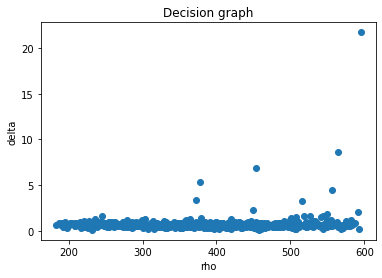

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

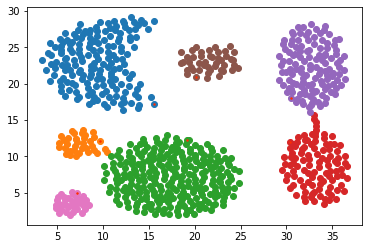

DBI is: 0.5071


In [13]:
model1 = DPC(16)
model1.decision_graph(Aggregation)
cluster_list1 = model1.cluster(Aggregation,0,3)
evaluate1 = davies_bouldin_score(Aggregation,cluster_list1)
print("DBI is: {:.4f}".format(evaluate1))

In [5]:
from sklearn.metrics import silhouette_score
score = silhouette_score(Aggregation, cluster_list1)

# 输出轮廓系数
print("聚类的轮廓系数:", score)


聚类的轮廓系数: 0.495434280647202


### Test2: D31

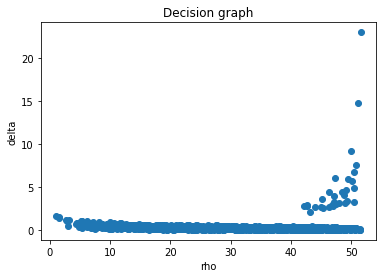

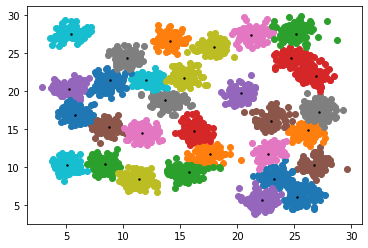

DBI is: 0.5510


In [59]:
model2 = DPC(1,"gauss")
model2.decision_graph(D31)
cluster_list2 = model2.cluster(D31,0,2)
evaluate2 = davies_bouldin_score(D31,cluster_list2)
print("DBI is: {:.4f}".format(evaluate2))

### Test3: R15

In [ ]:
model3 = DPC(5)
model3.decision_graph(R15)
cluster_list3 = model3.cluster(R15,0,1.5)
evaluate3 = davies_bouldin_score(R15,cluster_list3)
print("DBI is: {:.4f}".format(evaluate3))